**Chapter 14 – Deep Computer Vision Using Convolutional Neural Networks**

_This notebook contains all the sample code in chapter 14._

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0-preview.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Install TensorFlow
try:
  %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Unknown TensorFlow version: only exists in Colab.
Currently selected TF version: 1.x
Available versions:
 * 1.x
 * 2.x
TensorFlow 2.x selected.


A couple utility functions to plot grayscale and RGB images:

In [0]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# What is a Convolution?

In [0]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

# plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
# plt.axis("off") # Not shown in the book
# plt.show()

In [0]:
def crop(images):
    return images[150:220, 130:250]

Saving figure china_original


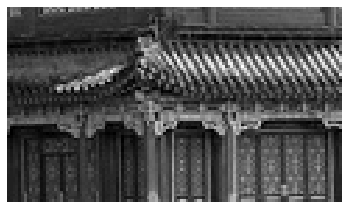

Saving figure china_vertical


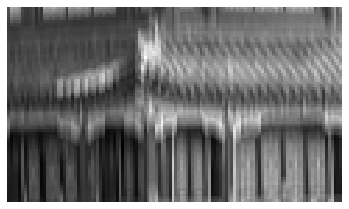

Saving figure china_horizontal


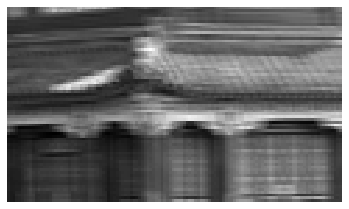

In [5]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

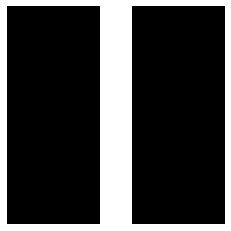

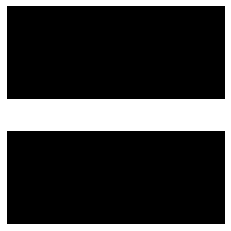

In [8]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

## Convolutional Layer

Using `keras.layers.Conv2D()`:

In [0]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

## VALID vs SAME padding

Using `"SAME"` padding is equivalent to padding manually using `manual_same_padding()` then using `"VALID"` padding (confusingly, `"VALID"` padding means no padding at all):

# Pooling layer

## Max pooling

In [0]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [11]:
cropped_images = np.array([crop(image) for image in images])
output = max_pool(cropped_images)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Saving figure china_max_pooling


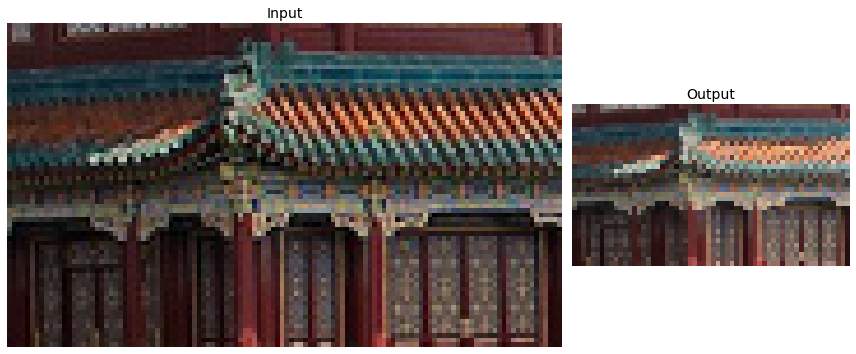

In [12]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

## Depth-wise pooling

## Average pooling

In [0]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [14]:
output_avg = avg_pool(cropped_images)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



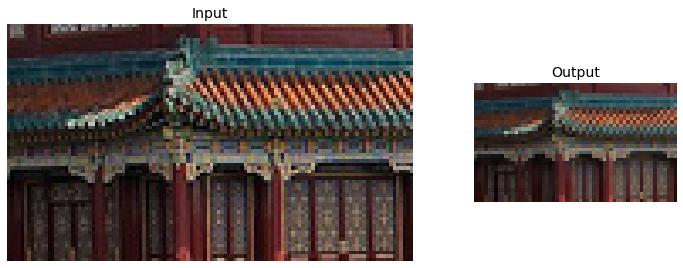

In [0]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

# Tackling Fashion MNIST With a CNN

In [15]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")
# DefaultConv2D(filters = #_of_filters) = keras.layers.Conv2D(filters = #_of_filters,kernel_size=3, activation='relu', padding='SAME')

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [17]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, validation_data=[X_valid, y_valid])
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 16s 295us/sample - loss: 0.7013 - accuracy: 0.7580 - val_loss: 0.3636 - val_accuracy: 0.8728
Epoch 2/20
55000/55000 [==============================] - 14s 262us/sample - loss: 0.4161 - accuracy: 0.8624 - val_loss: 0.3116 - val_accuracy: 0.8822
Epoch 3/20
55000/55000 [==============================] - 15s 265us/sample - loss: 0.3562 - accuracy: 0.8824 - val_loss: 0.2988 - val_accuracy: 0.8952
Epoch 4/20
55000/55000 [==============================] - 15s 264us/sample - loss: 0.3302 - accuracy: 0.8904 - val_loss: 0.2963 - val_accuracy: 0.8890
Epoch 5/20
55000/55000 [==============================] - 15s 270us/sample - loss: 0.3037 - accuracy: 0.8979 - val_loss: 0.2900 - val_accuracy: 0.8938
Epoch 6/20
55000/55000 [==============================] - 15s 267us/sample - loss: 0.2875 - accuracy: 0.9013 - val_loss: 0.3045 - val_accuracy: 0.8970
Epoch 7/20
55000/55000 [=====================

In [18]:
model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    keras.layers.BatchNormalization(),
    DefaultConv2D(filters=128),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    keras.layers.BatchNormalization(),
    DefaultConv2D(filters=256),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, validation_data=[X_valid, y_valid])
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 22s 396us/sample - loss: 0.6213 - accuracy: 0.7935 - val_loss: 0.3345 - val_accuracy: 0.8796
Epoch 2/20
55000/55000 [==============================] - 19s 347us/sample - loss: 0.3773 - accuracy: 0.8727 - val_loss: 0.2865 - val_accuracy: 0.8922
Epoch 3/20
55000/55000 [==============================] - 20s 365us/sample - loss: 0.3271 - accuracy: 0.8913 - val_loss: 0.2582 - val_accuracy: 0.9048
Epoch 4/20
55000/55000 [==============================] - 20s 371us/sample - loss: 0.2912 - accuracy: 0.9026 - val_loss: 0.2724 - val_accuracy: 0.9046
Epoch 5/20
55000/55000 [==============================] - 19s 350us/sample - loss: 0.2642 - accuracy: 0.9116 - val_loss: 0.2424 - val_accuracy: 0.9118
Epoch 6/20
55000/55000 [==============================] - 20s 358us/sample - loss: 0.2295 - accuracy: 0.9239 - val_loss: 0.2471 - val_accuracy: 0.9150
Epoch 7/20
55000/55000 [=====================

KeyboardInterrupt: ignored

## Using a Pretrained Model

In [19]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102973440/102967424 [==============================] - 1s 0us/step


In [20]:
len(model.layers)

177

In [0]:
# for layer in model.layers[:-1]:
#     layer.trainable = False

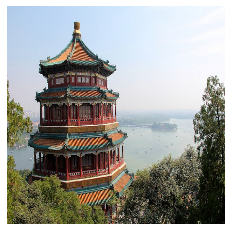

In [21]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


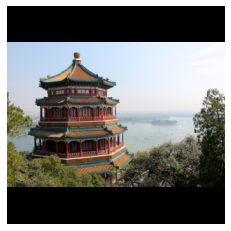

In [22]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

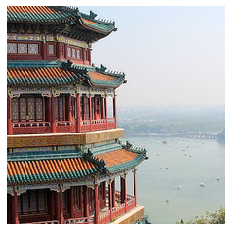

In [23]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

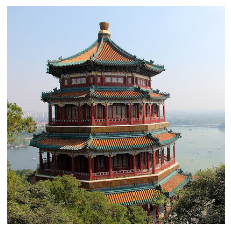

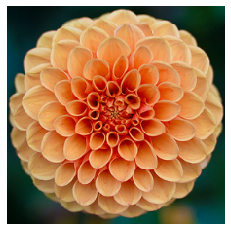

In [24]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [0]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [26]:
Y_proba.shape

(2, 1000)

In [28]:
Y_proba

array([[7.3548496e-09, 2.1553085e-08, 7.4699029e-09, ..., 1.7062443e-09,
        1.1173305e-07, 3.3828758e-08],
       [2.3477048e-07, 7.0270994e-06, 4.0479952e-07, ..., 5.4022170e-05,
        3.6675723e-05, 1.3372322e-04]], dtype=float32)

In [27]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

40960/35363 [==================================] - 0s 0us/step
Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%

